In [55]:
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

x_set = []
y_set = []

with open("dialog_acts.dat", 'r') as file:
    for line in file:
        y_set.append(line.split()[0])
        x_set.append(" ".join(line.split()[1:]).lower())
    # dialog_dataset = file.read()

y_set[0], x_set[0]
    

('inform', 'im looking for a moderately priced restaurant that serves')

In [57]:
#maybe split it in train, test and dev?

x_train, x_test = x_set[int(len(x_set)*0.15):], x_set[:int(len(x_set)*0.15)]
y_train, y_test = y_set[int(len(y_set)*0.15):], y_set[:int(len(y_set)*0.15)]
len(x_train), len(x_test), len(y_train), len(y_test)


y_train = pd.Series(y_train)
y_test = pd.Series(y_test)
y_train, word_list = pd.factorize(y_train)
y_test = pd.factorize(y_test)[0]
def to_cat(data, num_tokens):
    encoder = keras.layers.CategoryEncoding(num_tokens=num_tokens, output_mode="one_hot")
    y_train_cat = encoder(data)
    return y_train_cat


y_train_cat= to_cat(y_train, 15)
y_test_cat = to_cat(y_test, 15)

['how bout thai food', 'yes', 'noise']


In [36]:
from gensim.models.doc2vec import Doc2Vec,\
    TaggedDocument
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\karst\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [37]:
#Doc2Vec (Sentences to vector)
#We use this to convert the whole input paragraph to a vector
#Upon reading the exercise again, they seem to suggest using bag-of-words. However, I think this is better. Lets discuss with the TA!

tagged_x_data = [TaggedDocument(words=word_tokenize(doc.lower()), tags=[str(i)]) for i, doc in enumerate(x_train)]
model = Doc2Vec(vector_size=50,
                min_count=2, epochs=50)
#print(tagged_x_data)
model.build_vocab(tagged_x_data)
model.train(tagged_x_data,
            total_examples=model.corpus_count,
            epochs=model.epochs)

def to_vector(list_of_words):
    vectorized = [model.infer_vector(word_tokenize(doc.lower())) for doc in list_of_words]
    return np.array(vectorized)

 

In [58]:
#bag of words implementation
#src: https://www.askpython.com/python/examples/bag-of-words-model-from-scratch

from collections import defaultdict, Counter
import regex as re
def tokenization(data):
    tokenized = []
    for sent in data:
        tokens = word_tokenize(sent)
        token_sent = [w.lower() for w in tokens if w.isalpha() ]
        tokenized.extend(token_sent)
    tokenized = sorted(list(set(tokenized)))
    return tokenized

def word_extraction(sentence):    
    #ignore = ['a', "the", "is"]
    ignore = []    
    words = re.sub("[^\w]", " ",  sentence).split()    
    cleaned_text = [w.lower() for w in words if w not in ignore]    
    return cleaned_text


def generate_vec(data, vocab):
    vectors =[]
    for sentence in data:                
        bag_vector = np.zeros(len(vocab))  
        words = word_extraction(sentence)    
        for w in words:            
            for i,word in enumerate(vocab):               
                if word == w:                     
                    bag_vector[i] += 1
        vectors.append(bag_vector)
    return vectors

def generate_bow(train, test):       
    vocab = tokenization(train)  
    train =generate_vec(train, vocab)
    test = generate_vec(test, vocab)
    return train, test

x_train_bow, x_test_bow = generate_bow(x_train, x_test)
#bag_of_words(x_train_tokenized, vocab, word_with_index)



['how bout thai food', 'yes', 'noise', 'noise', 'thai food', 'dont care', 'what is the addre', 'what is the phone number', 'thank you goodbye', 'expensive', 'south', 'south', 'south', 'any', 'expensive', 'is there anything else', 'whats the address', 'thank you good bye', 'moderately priced restaurant', 'that serves traditional food', 'how about spanish food', 'how about spanish food', 'spanish food', 'yes', 'spanish food', 'okay address phone number and post code please', 'address', 'thank you good bye', 'yes good afternoon im looking for a restaurant in the north', 'the north part of town', 'belgium', 'is there an asian oriental restaurant in the north part of town', 'how about asian food', 'can i have the address and phone number', 'and phone number please', 'thank you good bye', 'im looking for a turkish restaurant', 'it doesnt matter', 'i dont care', 'address', 'address', 'thank you good bye', 'im looking for a cheap restaurant that serves swedish food', 'does it serve swedish ser

In [68]:
document_vectors = to_vector(x_train)
x_test_vector = to_vector(x_test)

In [65]:
def plot(history, epochs):
    fig, ax = plt.subplots()
    ax.plot(history.history["loss"], label = "loss")
    ax.plot(history.history["val_loss"], label = "Valditation loss")
    ax.set_title(f"Loss in {epochs} epochs")
    fig.legend()

    fig2, ax2 = plt.subplots()
    ax2.plot(history.history["accuracy"], label = "accuracy")
    ax2.plot(history.history["val_accuracy"], label = "Validation accuracy")
    ax2.set_title(f"Accuracy in {epochs} epochs")
    fig2.legend()

Epoch 1/12
339/339 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8313 - loss: 1.0149 - val_accuracy: 0.8060 - val_loss: 1.2828
Epoch 2/12
339/339 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9671 - loss: 0.1227 - val_accuracy: 0.8058 - val_loss: 1.5599
Epoch 3/12
339/339 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9787 - loss: 0.0815 - val_accuracy: 0.8092 - val_loss: 1.7601
Epoch 4/12
339/339 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9849 - loss: 0.0629 - val_accuracy: 0.8071 - val_loss: 1.8873
Epoch 5/12
339/339 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9876 - loss: 0.0527 - val_accuracy: 0.8084 - val_loss: 1.9730
Epoch 6/12
339/339 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9902 - loss: 0.0400 - val_accuracy: 0.8076 - val_loss: 2.0459
Epoch 7/12
339/339 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9889 - loss: 0.0419 - val_accuracy: 0.8078 - val_loss: 2.1374
Epoch 8/12
339/339 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9899 - loss: 0.0365 - val_accuracy: 0.

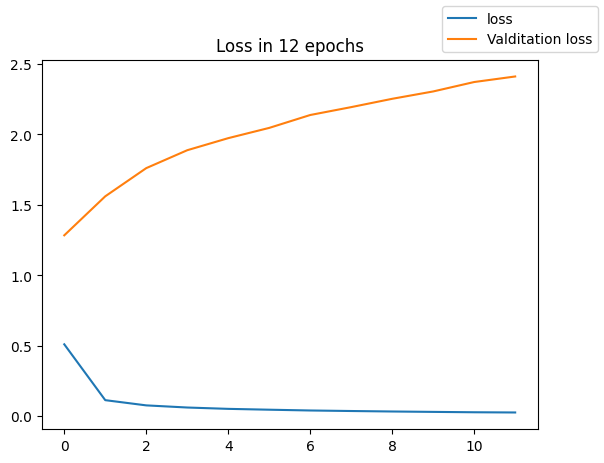

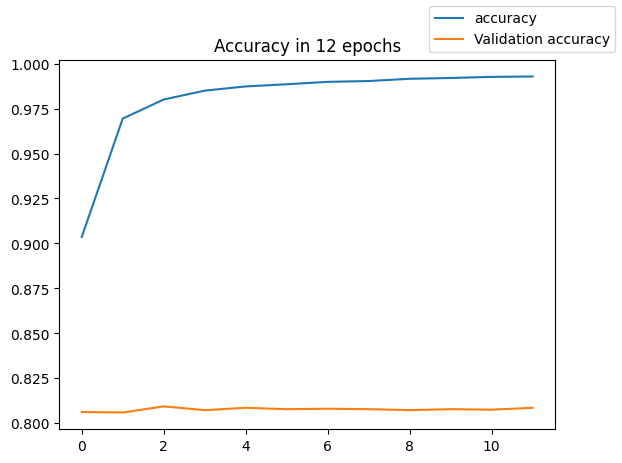

In [66]:
#FNN with BOW

epochs = 12
model_FNN = keras.Sequential()
model_FNN.add(keras.Input(shape=(731,)))
model_FNN.add(keras.layers.Dense(256, activation="relu"))
model_FNN.add(keras.layers.Dense(15, activation="softmax"))

model_FNN.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

history = model_FNN.fit(np.array(x_train_bow), y_train_cat, batch_size=64,
epochs=epochs, verbose=1,validation_data=(np.array(x_test_bow), y_test_cat))

plot(history, epochs)

Epoch 1/12
339/339 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6877 - loss: 1.2766 - val_accuracy: 0.7725 - val_loss: 1.1418
Epoch 2/12
339/339 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8932 - loss: 0.4002 - val_accuracy: 0.7754 - val_loss: 1.3387
Epoch 3/12
339/339 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9096 - loss: 0.3205 - val_accuracy: 0.7838 - val_loss: 1.4887
Epoch 4/12
339/339 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9190 - loss: 0.2846 - val_accuracy: 0.7895 - val_loss: 1.5282
Epoch 5/12
339/339 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9284 - loss: 0.2507 - val_accuracy: 0.7895 - val_loss: 1.6187
Epoch 6/12
339/339 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9356 - loss: 0.2246 - val_accuracy: 0.7919 - val_loss: 1.6570
Epoch 7/12
339/339 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9421 - loss: 0.2014 - val_accuracy: 0.7956 - val_loss: 1.6934
Epoch 8/12
339/339 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9453 - loss: 0.1900 - val_accuracy: 0.

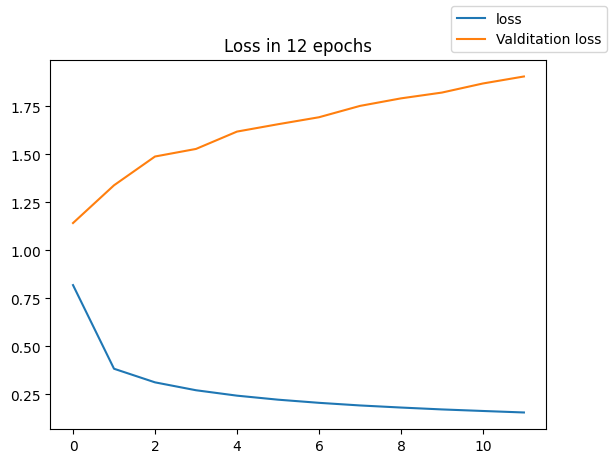

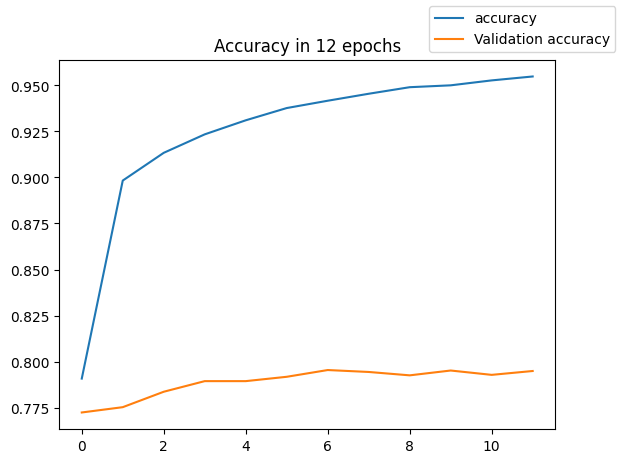

In [70]:
#FNN with word embeddings
epochs = 12
model_FNN = keras.Sequential()
model_FNN.add(keras.Input(shape=(50,)))
model_FNN.add(keras.layers.Dense(256, activation="relu"))
model_FNN.add(keras.layers.Dense(15, activation="softmax"))

model_FNN.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
history = model_FNN.fit(document_vectors, y_train_cat, batch_size=64,
epochs=12, verbose=1,validation_data=(x_test_vector, y_test_cat))

plot(history, epochs)

Epoch 1/12
339/339 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5944 - loss: 2.2676 - val_accuracy: 0.7838 - val_loss: 1.4494
Epoch 2/12
339/339 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8713 - loss: 1.1507 - val_accuracy: 0.7843 - val_loss: 1.1092
Epoch 3/12
339/339 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9062 - loss: 0.7353 - val_accuracy: 0.7835 - val_loss: 1.0356
Epoch 4/12
339/339 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9060 - loss: 0.5286 - val_accuracy: 0.7841 - val_loss: 1.0320
Epoch 5/12
339/339 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9117 - loss: 0.4257 - val_accuracy: 0.7945 - val_loss: 1.0547
Epoch 6/12
339/339 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9231 - loss: 0.3494 - val_accuracy: 0.7953 - val_loss: 1.0854
Epoch 7/12
339/339 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9338 - loss: 0.2936 - val_accuracy: 0.7995 - val_loss: 1.1204
Epoch 8/12
339/339 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9396 - loss: 0.2642 - val_accuracy: 0.

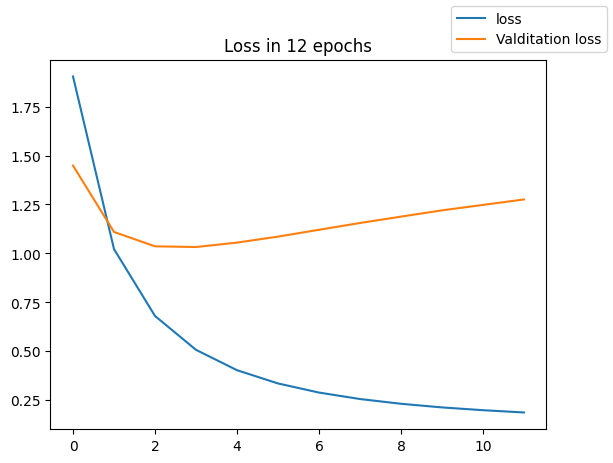

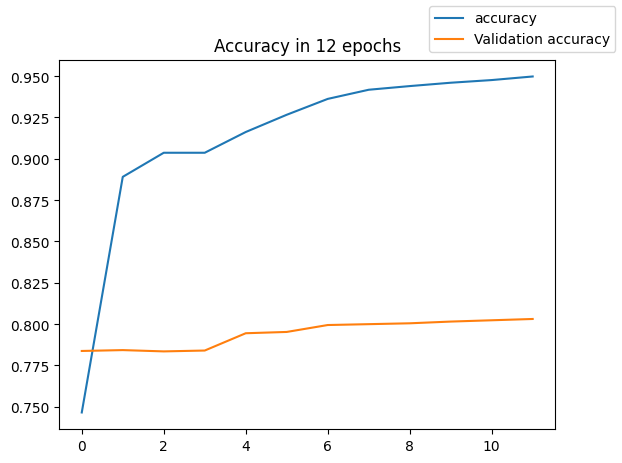

In [78]:
# Logistic regression with BOW
model_LR = keras.Sequential()
model_LR.add(keras.Input(shape=(731,)))
model_LR.add(keras.layers.Dense(15, activation="softmax"))

model_LR.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
history = model_LR.fit(np.array(x_train_bow), y_train_cat, batch_size=64, epochs=12, verbose=1,
                       validation_data=(np.array(x_test_bow), y_test_cat))

plot(history, epochs)

Epoch 1/12
339/339 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3741 - loss: 2.3176 - val_accuracy: 0.6915 - val_loss: 1.6680
Epoch 2/12
339/339 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6963 - loss: 1.4369 - val_accuracy: 0.7174 - val_loss: 1.3416
Epoch 3/12
339/339 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step - accuracy: 0.7198 - loss: 1.0793 - val_accuracy: 0.7305 - val_loss: 1.2318
Epoch 4/12
339/339 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - accuracy: 0.7350 - loss: 0.9097 - val_accuracy: 0.7328 - val_loss: 1.1829
Epoch 5/12
339/339 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7618 - loss: 0.8087 - val_accuracy: 0.7367 - val_loss: 1.1609
Epoch 6/12
339/339 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step - accuracy: 0.7938 - loss: 0.7185 - val_accuracy: 0.7441 - val_loss: 1.1533
Epoch 7/12
339/339 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8160 - loss: 0.6716 - val_accuracy: 0.7501 - val_loss: 1.1536
Epoch 8/12
339/339 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8262 - loss: 0.6444 - val_accura

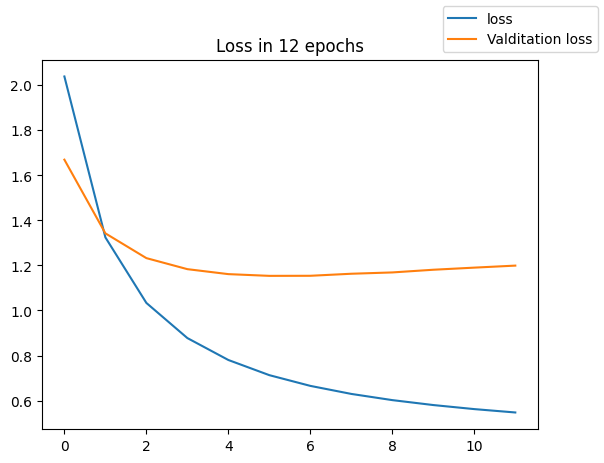

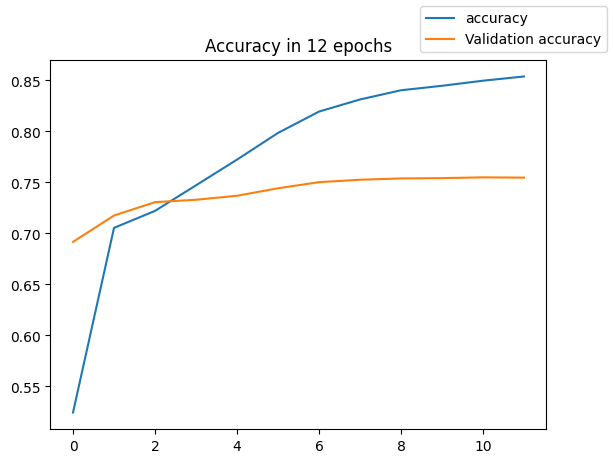

In [80]:
# Logistic regression with word embeddings
model_LR = keras.Sequential()
model_LR.add(keras.Input(shape=(50,)))
model_LR.add(keras.layers.Dense(15, activation="softmax"))

model_LR.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
history = model_LR.fit(document_vectors, y_train_cat, batch_size=64, epochs=12, verbose=1,
                       validation_data=(x_test_vector, y_test_cat))

plot(history, epochs)

In [43]:

Xnew = ["yes", "thai food", "what is the cheapest restaurant in london?"]
# make a prediction
X_new_vector = to_vector(Xnew)
X_new_vector = np.array(X_new_vector)
ynew = model_LR.predict(X_new_vector)
# show the inputs and predicted outputs

for i in range(len(Xnew)):
 print("X=%s, Predicted=%s" % (Xnew[i], word_list[np.argmax(ynew[i])]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
X=yes, Predicted=affirm
X=thai food, Predicted=inform
X=what is the cheapest restaurant in london?, Predicted=inform
